# Tutorial 02

## basics of wrapped-in pseudo-$C_\ell$ estimator

By default we use [NaMaster](https://github.com/LSSTDESC/NaMaster).

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp
import afra as af
from afra.tools.ps_estimator import pstimator
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
NSIDE = 128

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
map30 = map30f + mapcmb
map95 = map95f + mapcmb
map150 = map150f + mapcmb
map353 = map353f + mapcmb

mask = hp.read_map('./data/ali_mask.fits',dtype=np.float32,verbose=0)

#### use `pstimator` functions (with NaMaster support)

- call the `pstimator` only once

(1, 384)

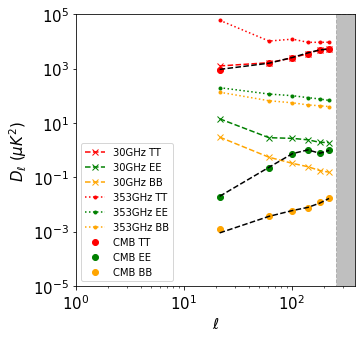

In [3]:
est = pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=6.0,psbin=40)

auto_cmb_t = est.auto_t(mapcmb[0].reshape(1,-1))
auto_cmb_eb = est.auto_eb(mapcmb[1:].reshape(2,-1))
auto_30_t = est.auto_t(map30[0].reshape(1,-1))
auto_30_eb = est.auto_eb(map30[1:].reshape(2,-1))
auto_353_t = est.auto_t(map353[0].reshape(1,-1))
auto_353_eb = est.auto_eb(map353[1:].reshape(2,-1))

# calculate binned CMB band-power from input Cl
cmb_dl = np.zeros((4,len(est.modes)))
cmb_dl[0] = est.modes
for i in range(len(est.modes)):
    lrange = np.array(est._b.get_ell_list(i))
    factor = 0.5*lrange*(lrange+1)/np.pi
    w = np.array(est._b.get_weight_list(i))
    for j in range(3):
        cmb_dl[j+1,i] = np.sum(w*cmb_cl[j,lrange]*factor)

fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(auto_cmb_t[0],auto_cmb_t[1],
           color='red',marker='o',label=r'CMB TT')
ax.scatter(auto_cmb_eb[0],auto_cmb_eb[1],
           color='green',marker='o',label=r'CMB EE')
ax.scatter(auto_cmb_eb[0],auto_cmb_eb[2],
           color='orange',marker='o',label=r'CMB BB')

ax.plot(auto_30_t[0],auto_30_t[1],
        color='red',linestyle='--',marker='x',label=r'30GHz TT')
ax.plot(auto_30_eb[0],auto_30_eb[1],
        color='green',linestyle='--',marker='x',label=r'30GHz EE')
ax.plot(auto_30_eb[0],auto_30_eb[2],
        color='orange',linestyle='--',marker='x',label=r'30GHz BB')

ax.plot(auto_353_t[0],auto_353_t[1],
        color='red',linestyle=':',marker='.',label=r'353GHz TT')
ax.plot(auto_353_eb[0],auto_353_eb[1],
        color='green',linestyle=':',marker='.',label=r'353GHz EE')
ax.plot(auto_353_eb[0],auto_353_eb[2],
        color='orange',linestyle=':',marker='.',label=r'353GHz BB')

#ax.plot(0.5*ell*(ell+1)/np.pi*cmb_cl[0],
#        color='black',linestyle='-')
#ax.plot(0.5*ell*(ell+1)/np.pi*cmb_cl[1],
#        color='black',linestyle='--')
#ax.plot(0.5*ell*(ell+1)/np.pi*cmb_cl[2],
#        color='black',linestyle=':')
ax.plot(cmb_dl[0],cmb_dl[1],color='k',linestyle='--')
ax.plot(cmb_dl[0],cmb_dl[2],color='k',linestyle='--')
ax.plot(cmb_dl[0],cmb_dl[3],color='k',linestyle='--')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-5,1e-5),(1e5,1e5),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-5,1.e5))
ax.set_xlim((1,3*NSIDE))

- PS estimator function correctness check, here we utilize **workspace** recorded from the previous runs of `pstimator`.

(1, 384)

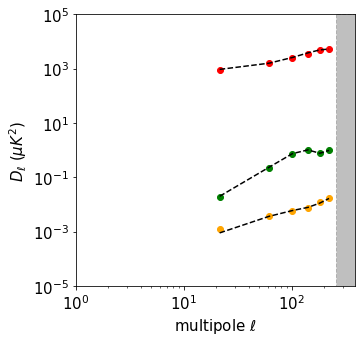

In [4]:
cross_cmb_t = est.cross_t(np.vstack([mapcmb[0],mapcmb[0]]),auto_cmb_t[-1])
cross_cmb_eb = est.cross_eb(np.vstack([mapcmb[1:].reshape(2,-1),mapcmb[1:].reshape(2,-1)]),auto_cmb_eb[-1])

fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(cross_cmb_t[0],cross_cmb_t[1],
           color='red',marker='o')
ax.scatter(cross_cmb_eb[0],cross_cmb_eb[1],
           color='green',marker='o')
ax.scatter(cross_cmb_eb[0],cross_cmb_eb[2],
           color='orange',marker='o')

ax.plot(cmb_dl[0],cmb_dl[1],color='k',linestyle='--')
ax.plot(cmb_dl[0],cmb_dl[2],color='k',linestyle='--')
ax.plot(cmb_dl[0],cmb_dl[3],color='k',linestyle='--')

#ax.plot(0.5*ell*(ell+1)/np.pi*cmb_cl[0],
#        color='black',linestyle='-')
#ax.plot(0.5*ell*(ell+1)/np.pi*cmb_cl[1],
#        color='black',linestyle='--')
#ax.plot(0.5*ell*(ell+1)/np.pi*cmb_cl[2],
#        color='black',linestyle=':')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-5,1e-5),(1e5,1e5),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
#ax.legend(loc=3)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-5,1.e5))
ax.set_xlim((1,3*NSIDE))

#### play with beams

In [5]:
deg = 2.
fwhm = deg*np.pi/180.  # beam fwhm

map30_s = hp.smoothing(map30,fwhm=fwhm,verbose=0)
map30_s[:,mask<1.] = 0.

est = pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=6.0,psbin=40)
auto_30_t = est.auto_t(map30[0].reshape(1,-1))
auto_30_s0 = est.auto_t(map30_s[0].reshape(1,-1))
auto_30_s1 = est.auto_t(map30_s[0].reshape(1,-1),fwhms=fwhm)

map30_q = hp.smoothing(map30,fwhm=2*fwhm,verbose=0)
map30_q[:,mask<1.] = 0.

auto_30_q0 = est.auto_t(map30_q[0].reshape(1,-1))
auto_30_q1 = est.auto_t(map30_q[0].reshape(1,-1),fwhms=2*fwhm)

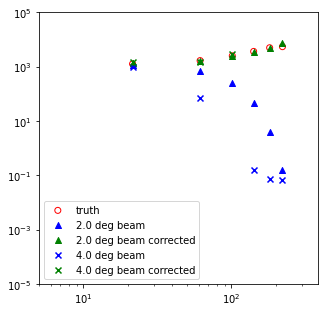

In [6]:
fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(auto_30_t[0],auto_30_t[1],color='red',marker='o',facecolors='none',label='truth')
ax.scatter(auto_30_s0[0],auto_30_s0[1],color='blue',marker='^',label=str(deg)+' deg beam')
ax.scatter(auto_30_s1[0],auto_30_s1[1],color='green',marker='^',label=str(deg)+' deg beam corrected')
ax.scatter(auto_30_q0[0],auto_30_q0[1],color='blue',marker='x',label=str(2*deg)+' deg beam')
ax.scatter(auto_30_q1[0],auto_30_q1[1],color='green',marker='x',label=str(2*deg)+' deg beam corrected')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim((1.e-5,1.e5))
ax.set_xlim((5,3*NSIDE))
ax.legend(loc=3)

#### play with inhomogeneous noise

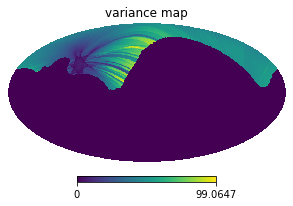

In [7]:
noise30 = hp.read_map('./data/plkvar_30.fits',field=[0,1,2],dtype=np.float64,verbose=0)
noise30[:,mask<1.] = 0.

fig = plt.figure(figsize=(5,5))
gs = gsp.GridSpec(5, 5)
fig.add_subplot(gs[0:5, 0:5])
hp.mollview(noise30[0],title='variance map',hold=True)

In [8]:
%%time
nsamp = 20
auto_30_nt = np.zeros((nsamp,len(auto_30_t[0])))
auto_30_ne = np.zeros((nsamp,len(auto_30_t[0])))
auto_30_nb = np.zeros((nsamp,len(auto_30_t[0])))
noise_30_t = np.zeros((nsamp,len(auto_30_t[0])))
noise_30_e = np.zeros((nsamp,len(auto_30_t[0])))
noise_30_b = np.zeros((nsamp,len(auto_30_t[0])))
for i in range(nsamp):
    n = np.random.normal(size=noise30.shape)
    n = n*np.sqrt(noise30)
    map30n = map30+n
    est = pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=6.0,psbin=40)
    auto_30_nt[i] = est.auto_t(map30n[0].reshape(1,-1))[1]
    ebtmp = est.auto_eb(map30n[1:].reshape(2,-1))
    auto_30_ne[i] = ebtmp[1]
    auto_30_nb[i] = ebtmp[2]
    noise_30_t[i] = est.auto_t(n[0].reshape(1,-1))[1]
    ebtmp = est.auto_eb(n[1:].reshape(2,-1))
    noise_30_e[i] = ebtmp[1]
    noise_30_b[i] = ebtmp[2]

CPU times: user 4min 49s, sys: 546 ms, total: 4min 50s
Wall time: 38.1 s


(10, 384)

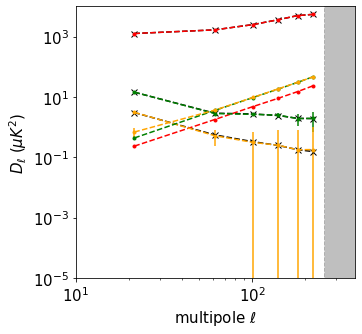

In [9]:
fig,ax = plt.subplots(figsize=(5,5))

ax.plot(auto_30_t[0],auto_30_t[1],
        color='k',linestyle='--',marker='x',label=r'30GHz TT')
ax.plot(auto_30_eb[0],auto_30_eb[1],
        color='k',linestyle='--',marker='x',label=r'30GHz EE')
ax.plot(auto_30_eb[0],auto_30_eb[2],
        color='k',linestyle='--',marker='x',label=r'30GHz BB')

ax.errorbar(auto_30_t[0],np.mean(auto_30_nt,axis=0)-np.mean(noise_30_t,axis=0),np.std(auto_30_nt,axis=0),
            color='red',linestyle='--',marker='.')
ax.errorbar(auto_30_eb[0],np.mean(auto_30_ne,axis=0)-np.mean(noise_30_e,axis=0),np.std(auto_30_ne,axis=0),
            color='green',linestyle='--',marker='.')
ax.errorbar(auto_30_eb[0],np.mean(auto_30_nb,axis=0)-np.mean(noise_30_b,axis=0),np.std(auto_30_nb,axis=0),
            color='orange',linestyle='--',marker='.')

ax.plot(auto_30_t[0],np.mean(noise_30_t,axis=0),np.std(noise_30_t,axis=0),
       color='red',linestyle='--',marker='.')
ax.errorbar(auto_30_eb[0],np.mean(noise_30_e,axis=0),np.std(noise_30_e,axis=0),
            color='green',linestyle='--',marker='.')
ax.errorbar(auto_30_eb[0],np.mean(noise_30_b,axis=0),np.std(noise_30_b,axis=0),
            color='orange',linestyle='--',marker='.')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-5,1e-5),(1e5,1e5),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-5,1.e4))
ax.set_xlim((10,3*NSIDE))

#### band power estimation leakage?

In [10]:
lmax = 300  # Nside 128
resamp = 20
est = pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=6.0,psbin=40)

# calculate binned CMB band-power from input Cl
def expected_dl(input_cl):
    output_dl = np.zeros(len(est.modes))
    for i in range(len(est.modes)):
        lrange = np.array(est._b.get_ell_list(i))
        factor = 0.5*lrange*(lrange+1)/np.pi
        w = np.array(est._b.get_weight_list(i))
        output_dl[i] = np.sum(w*input_cl[lrange]*factor)
    return output_dl

In [11]:
def M_tt2tt(bin_pivot):
    cl_in = np.zeros((4,800))
    l_pivot = est._b.get_ell_list(bin_pivot)
    cl_in[0,l_pivot] = 1.
    samples = np.zeros((resamp,len(est.modes)))
    for k in range(resamp):
        intmap = hp.synfast(cl_in,nside=NSIDE,new=True,verbose=0)[0]
        samples[k] = est.auto_t(intmap.reshape(1,-1))[1]
    return samples, expected_dl(cl_in[0])

def M_ee2ee(bin_pivot):
    cl_in = np.zeros((4,800))
    l_pivot = est._b.get_ell_list(bin_pivot)
    cl_in[1,l_pivot] = 1.
    samples = np.zeros((resamp,len(est.modes)))
    for k in range(resamp):
        intmap = hp.synfast(cl_in,nside=NSIDE,new=True,verbose=0)[1:]
        samples[k] = est.auto_eb(intmap)[1]
    return samples, expected_dl(cl_in[1])

def M_ee2bb(bin_pivot):
    cl_in = np.zeros((4,800))
    l_pivot = est._b.get_ell_list(bin_pivot)
    cl_in[1,l_pivot] = 1.
    samples = np.zeros((resamp,len(est.modes)))
    for k in range(resamp):
        intmap = hp.synfast(cl_in,nside=NSIDE,new=True,verbose=0)[1:]
        samples[k] = est.auto_eb(intmap)[2]
    return samples, expected_dl(cl_in[2])

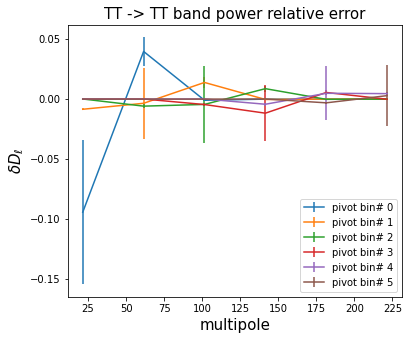

In [12]:
fig,ax = plt.subplots(figsize=(6,5))

for i in range(len(est.modes)):
    result = M_tt2tt(i)
    mean = np.mean(result[0],axis=0)
    std = np.std(result[0],axis=0)
    ax.errorbar(est.modes,(mean-result[1])/mean[i],std/mean[i],label='pivot bin# '+str(i))

ax.set_xlabel('multipole',fontsize=15)
ax.set_ylabel(r'$\delta D_\ell$',fontsize=15)
ax.set_title('TT -> TT band power relative error',fontsize=15)
ax.legend(loc=4)

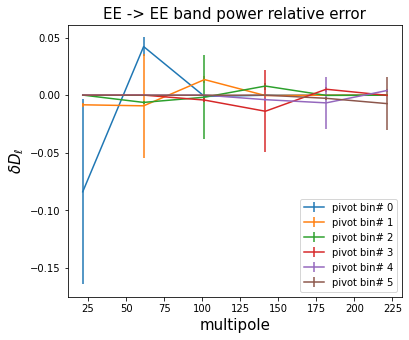

In [13]:
fig,ax = plt.subplots(figsize=(6,5))

for i in range(len(est.modes)):
    result = M_tt2tt(i)
    mean = np.mean(result[0],axis=0)
    std = np.std(result[0],axis=0)
    ax.errorbar(est.modes,(mean-result[1])/mean[i],std/mean[i],label='pivot bin# '+str(i))

ax.set_xlabel('multipole',fontsize=15)
ax.set_ylabel(r'$\delta D_\ell$',fontsize=15)
ax.set_title('EE -> EE band power relative error',fontsize=15)
ax.legend(loc=4)

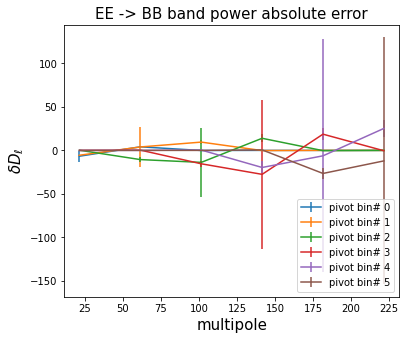

In [14]:
fig,ax = plt.subplots(figsize=(6,5))

for i in range(len(est.modes)):
    result = M_tt2tt(i)
    mean = np.mean(result[0],axis=0)
    std = np.std(result[0],axis=0)
    ax.errorbar(est.modes,(mean-result[1]),std,label='pivot bin# '+str(i))

ax.set_xlabel('multipole',fontsize=15)
ax.set_ylabel(r'$\delta D_\ell$',fontsize=15)
ax.set_title('EE -> BB band power absolute error',fontsize=15)
ax.legend(loc=4)

end